In [1]:
import os
import shutil
import random
from PIL import Image
import cv2

In [2]:
source = '/kaggle/input/rice-leaf-images/rice_images'

brownspot = os.path.join(source, '_BrownSpot')
healthy = os.path.join(source, '_Healthy')
hispa = os.path.join(source, '_Hispa')
leafblast = os.path.join(source, '_LeafBlast')

In [3]:
train = '/kaggle/working/train'
validation = '/kaggle/working/validation'

brownspot_train = os.path.join(train, 'brownspot')
healthy_train = os.path.join(train, 'healthy')
hispa_train = os.path.join(train, 'hispa')
leafblast_train = os.path.join(train, 'leafblast')

brownspot_validation = os.path.join(validation, 'brownspot')
healthy_validation = os.path.join(validation, 'healthy')
hispa_validation = os.path.join(validation, 'hispa')
leafblast_validation = os.path.join(validation, 'leafblast')

if not os.path.exists(train):
    os.mkdir(train)
    os.mkdir(brownspot_train)
    os.mkdir(healthy_train)
    os.mkdir(hispa_train)
    os.mkdir(leafblast_train)

if not os.path.exists(validation):
    os.mkdir(validation)
    os.mkdir(brownspot_validation)
    os.mkdir(healthy_validation)
    os.mkdir(hispa_validation)
    os.mkdir(leafblast_validation)

In [4]:
def split_and_resize(source, destination_train, destination_validation, split_size, img_size):
    files = []
    for filename in os.listdir(source):
        file = source + '/' + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)
    validation_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[:validation_length]

    for filename in training_set:
        this_file = source + '/' + filename
        destination = destination_train + '/' + filename
        img = Image.open(this_file)
        img = img.resize((img_size, img_size))
        img.save(destination)
    print("Training set of " + source + " created.")

    for filename in validation_set:
        this_file = source + '/' + filename
        destination = destination_validation + '/' + filename
        img = Image.open(this_file)
        img = img.resize((img_size, img_size))
        img.save(destination)
    print("Validation set of " + source + " created.")


split_size = .9
img_size = 224

split_and_resize(brownspot, brownspot_train, brownspot_validation, split_size, img_size)
split_and_resize(healthy, healthy_train, healthy_validation, split_size, img_size)
split_and_resize(hispa, hispa_train, hispa_validation, split_size, img_size)
split_and_resize(leafblast, leafblast_train, leafblast_validation, split_size, img_size)

Training set of /kaggle/input/rice-leaf-images/rice_images/_BrownSpot created.
Validation set of /kaggle/input/rice-leaf-images/rice_images/_BrownSpot created.
Training set of /kaggle/input/rice-leaf-images/rice_images/_Healthy created.
Validation set of /kaggle/input/rice-leaf-images/rice_images/_Healthy created.
Training set of /kaggle/input/rice-leaf-images/rice_images/_Hispa created.
Validation set of /kaggle/input/rice-leaf-images/rice_images/_Hispa created.
Training set of /kaggle/input/rice-leaf-images/rice_images/_LeafBlast created.
Validation set of /kaggle/input/rice-leaf-images/rice_images/_LeafBlast created.


In [5]:
import pandas as pd

df = pd.DataFrame(columns=['Train', 'Validation'])
df['Train'] = [len(os.listdir(brownspot_train)), len(os.listdir(healthy_train)), len(os.listdir(hispa_train)), len(os.listdir(leafblast_train))]
df['Validation'] = [len(os.listdir(brownspot_validation)), len(os.listdir(healthy_validation)), len(os.listdir(hispa_validation)), len(os.listdir(leafblast_validation))]
df.index = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
df

,Train,Validation
BrownSpot,470,53
Healthy,1339,149
Hispa,508,57
LeafBlast,701,78


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                      rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train,
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    target_size=(img_size, img_size))

validation_generator = validation_datagen.flow_from_directory(validation,
                                                                batch_size=10,  
                                                                class_mode='categorical',
                                                                target_size=(img_size, img_size))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Found 3018 images belonging to 4 classes.
Found 337 images belonging to 4 classes.


In [7]:
import tensorflow_hub as hub

pre_trained_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2", trainable=True)

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')

])

In [8]:
model.build([None, img_size, img_size, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,608,276
Trainable params: 6,547,668
Non-trainable params: 60,608
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('rice_disease.h5',
                                monitor='val_acc',
                                mode='max',
                                save_best_only=True,
                                verbose=1)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [11]:
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    callbacks=[checkpoint],
                    validation_data=validation_generator)


Epoch 1/50
302/302 [==============================] - ETA: 0s - loss: 1.1458 - acc: 0.5315
Epoch 1: val_acc improved from -inf to 0.56380, saving model to rice_disease.h5
302/302 [==============================] - 113s 173ms/step - loss: 1.1458 - acc: 0.5315 - val_loss: 0.9897 - val_acc: 0.5638
Epoch 2/50
302/302 [==============================] - ETA: 0s - loss: 0.9807 - acc: 0.6150
Epoch 2: val_acc improved from 0.56380 to 0.61128, saving model to rice_disease.h5
302/302 [==============================] - 49s 163ms/step - loss: 0.9807 - acc: 0.6150 - val_loss: 0.9233 - val_acc: 0.6113
Epoch 3/50
302/302 [==============================] - ETA: 0s - loss: 0.9444 - acc: 0.6382
Epoch 3: val_acc improved from 0.61128 to 0.72107, saving model to rice_disease.h5
302/302 [==============================] - 50s 167ms/step - loss: 0.9444 - acc: 0.6382 - val_loss: 0.7661 - val_acc: 0.7211
Epoch 4/50
302/302 [==============================] - ETA: 0s - loss: 0.8908 - acc: 0.6484
Epoch 4: val_acc 

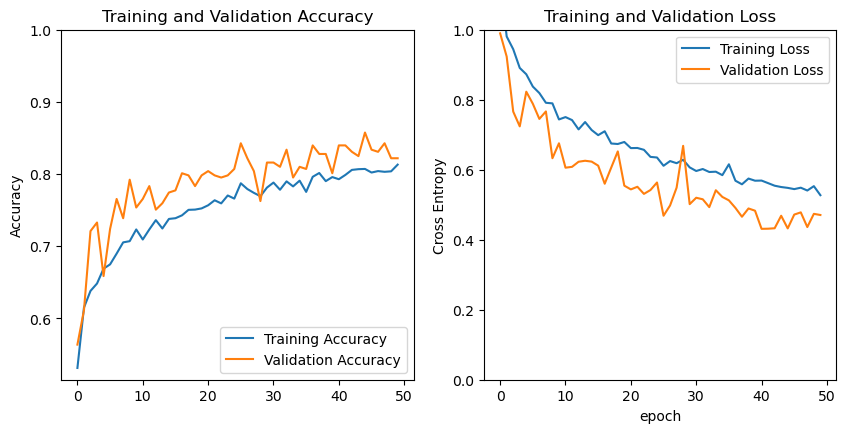

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Found 337 images belonging to 4 classes.
34/34 [==============================] - 2s 23ms/step


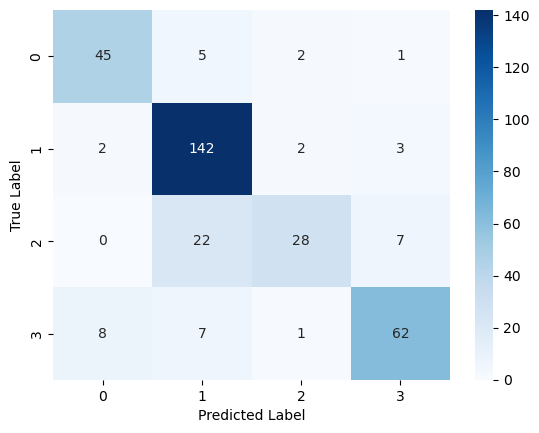

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

test_generator = validation_datagen.flow_from_directory(validation,
                                                        batch_size=10,          
                                                        class_mode='categorical',
                                                        target_size=(img_size, img_size),
                                                        shuffle=False)

test_generator.reset()

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [14]:
print('Classification Report')
target_names = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   BrownSpot       0.82      0.85      0.83        53
     Healthy       0.81      0.95      0.87       149
       Hispa       0.85      0.49      0.62        57
   LeafBlast       0.85      0.79      0.82        78

    accuracy                           0.82       337
   macro avg       0.83      0.77      0.79       337
weighted avg       0.83      0.82      0.81       337



In [15]:
model.save('rice_disease_1.h5')